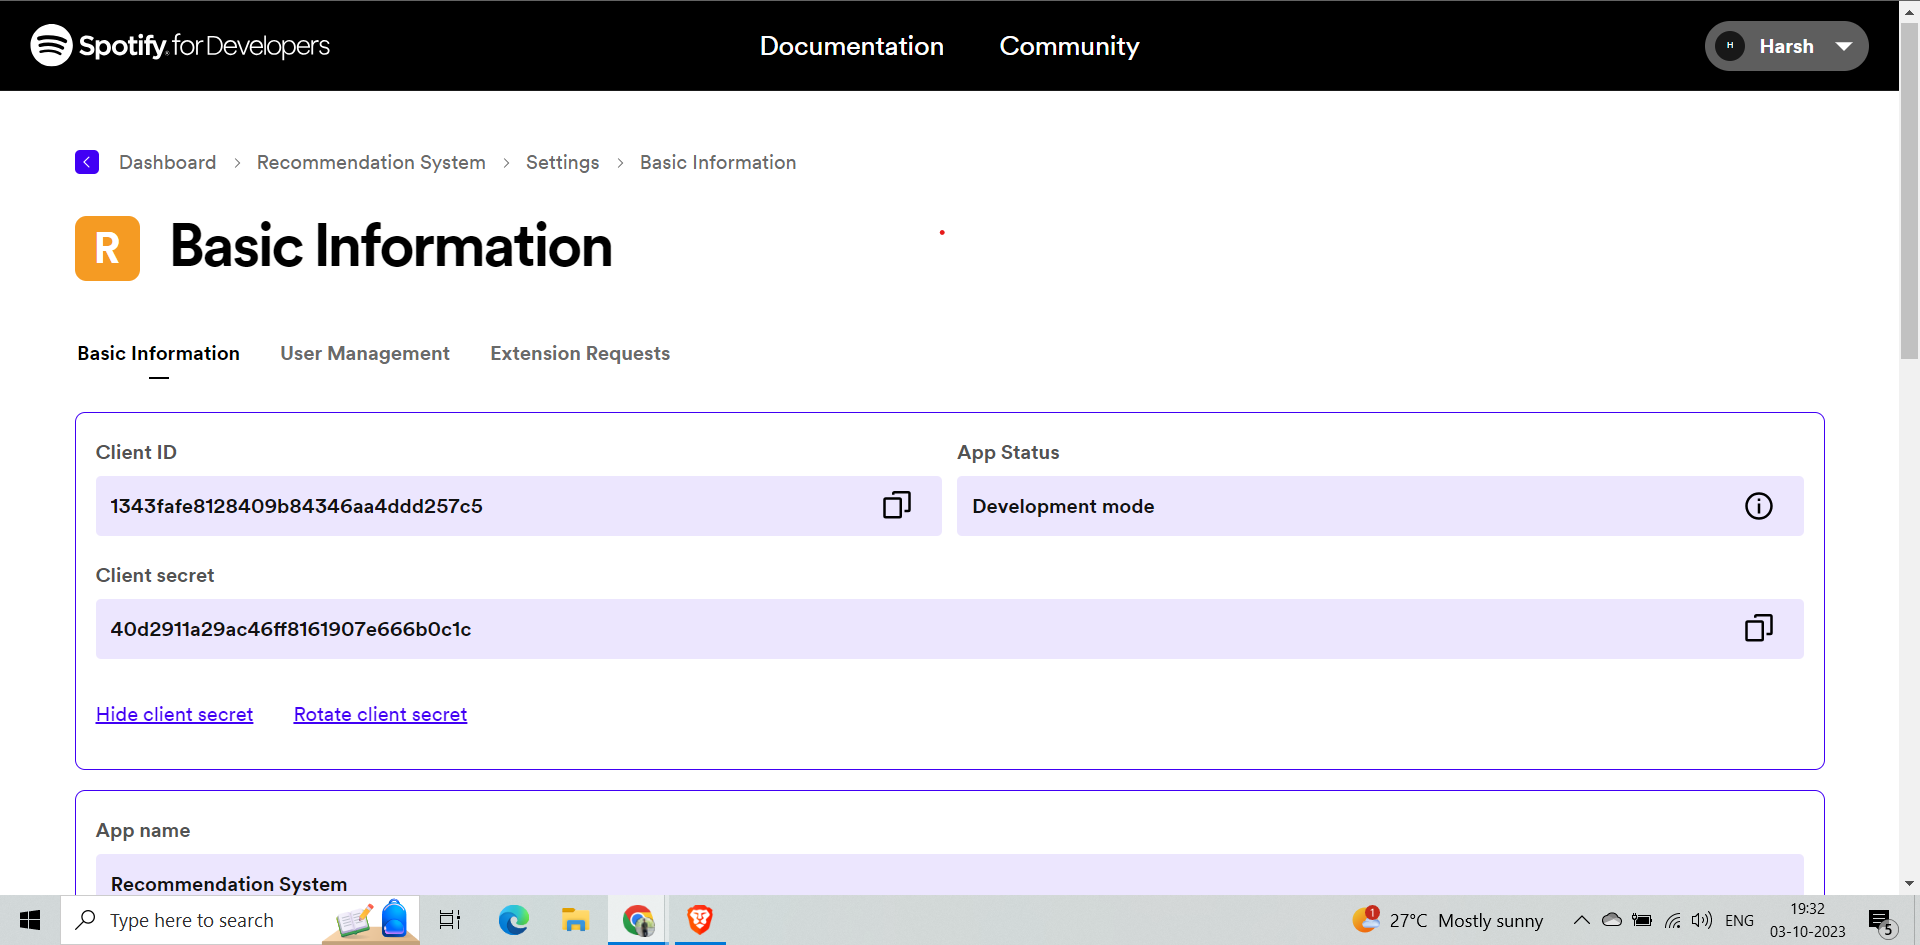

To get started with building a Music Recommendation System, we first need to have an access token(Temporary Authorization Credential).

In [20]:
import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = '1343fafe8128409b84346aa4ddd257c5'
CLIENT_SECRET = '40d2911a29ac46ff8161907e666b0c1c'

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In the above code, The CLIENT_ID and CLIENT_SECRET variables hold my credentials that uniquely identify the application making requests to the Spotify API. These credentials are obtained when a developer registers their application with Spotify’s developer dashboard. The Client ID identifies the application, while the Client Secret is a confidential key used for authentication.

In [21]:
pip install spotipy


 Now i'm defining a function responsible for collecting music data from any playlist on Spotify using the Spotipy library:

In [22]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

We can use the function to collect music data from any playlist on Spotify:



In [23]:
playlist_id = '37i9dQZF1DWXVJK4aT7pmk'

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

                     Track Name                       Artists  \
0                        Softly             Karan Aujla, Ikky   
1                  Still Rollin                         Shubh   
2                       Mi Amor          Sharn, 40k, The Paul   
3                       Cheques                         Shubh   
4   Bachke Bachke (feat. Yarah)      Karan Aujla, Ikky, Yarah   
..                          ...                           ...   
68                  Summer High                    AP Dhillon   
69                        Hirni                 Navaan Sandhu   
70                    Love Sick  Sidhu Moose Wala, AR Paisley   
71                 Fully Loaded      Tegi Pannu, Manni Sandhu   
72              Everybody Hurts              Sidhu Moose Wala   

         Album Name                Album ID                Track ID  \
0   Making Memories  3BGU0BqGwBkYDHpfCWFm7I  0YQJoDL6f46J0n1rOVkpxJ   
1      Still Rollin  5AivaZj0CiQJoDWqVH2pbh  6oz1L5jcqZWYuId7nxvIan   
2     

Importing Libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

Checking for Nul Values

In [25]:
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


While providing music recommendations to users, it is important to recommend the latest releases. For this, we need to give more weight to the latest releases in the recommendations.

In [26]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date):
    # Convert the release date to datetime object
    release_date = datetime.strptime(release_date, '%Y-%m-%d')

    # Calculate the time span between release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight

Now let’s normalize the music features before moving forward:

In [27]:
# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key',
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

Generating music recommendations based on the music audio features:

In [28]:
# a function to get content-based recommendations based on music features
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

Now here’s the function to generate music recommendations based on weighted popularity and combine it with the recommendations of the content-based filtering method using the hybrid approach:



In [29]:
# a function to get hybrid recommendations based on weighted popularity
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Combine content-based and popularity-based recommendations based on weighted popularity
    hybrid_recommendations = content_based_rec
    hybrid_recommendations = hybrid_recommendations.append({
        'Track Name': input_song_name,
        'Artists': music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0],
        'Album Name': music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0],
        'Release Date': music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0],
        'Popularity': weighted_popularity_score
    }, ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]


    return hybrid_recommendations

Now here’s how we can test the final function to generate music recommendations:



In [31]:
input_song_name = "Daku"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations)

Hybrid recommended songs for 'Daku':
       Track Name                  Artists  \
0  Aam Jahe Munde  Parmish Verma, PARDHAAN   
3      Afterhours  Bir, Dhanju, thiarajxtt   
2           Shape                     Kaka   
4           Scars               AP Dhillon   
1     Showstopper                    JERRY   

                                          Album Name Release Date  Popularity  
0                                     Aam Jahe Munde   2020-05-02        77.0  
3                                         Afterhours   2022-07-06        73.0  
2                                       Another Side   2023-01-15        72.0  
4  First of a Kind (From the Amazon Original Series)   2023-09-08        71.0  
1                                        Showstopper   2023-07-21        70.0  


<ipython-input-29-3de633f34e34>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hybrid_recommendations = hybrid_recommendations.append({
